In [1]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *


from util.transform_algebra import *
from util.util_func import *

from sklearn import linear_model

3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]


In [2]:
#import ing dataset

# marmotte
# grand salon
# full_dataset = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/grand_salon_20_01_b/slip_dataset_all.pkl')
# full_dataset_length = len(full_dataset)
# dataset_snow = full_dataset[:int(full_dataset_length/2)]
# dataset_test = full_dataset[int(full_dataset_length/2):]
# dataset_test.index = np.arange(0, len(dataset_test))
# grand axe
# dataset_snow = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/slip_dataset_all.pkl')
# dataset_test = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_b/slip_dataset_all.pkl')

# husky
#grand salon
# full_dataset = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/husky/grand_salon_b_deflated/slip_dataset_all.pkl')
# full_dataset_length = len(full_dataset)
# dataset_snow = full_dataset[:int(full_dataset_length/2)]
# dataset_test = full_dataset[int(full_dataset_length/2):]
# dataset_test.index = np.arange(0, len(dataset_test))

#boreal
full_dataset = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/husky/boreal/slip_dataset_all.pkl')
full_dataset_length = len(full_dataset)
dataset_snow = full_dataset[:int(full_dataset_length/2)]
dataset_test = full_dataset[int(full_dataset_length/2):]
dataset_test.index = np.arange(0, len(dataset_test))



# '/home/dominic/repos/norlab_WMRD/data/marmotte/grand_salon_20_01_b/slip_dataset_all.pkl' # grand salon
# '/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/slip_dataset_all.pkl' # snow

print(dataset_snow)
print(dataset_test)

     init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
0           0.0         0.0         0.0            0.0             0.0   
1           0.0         0.0         0.0            0.0             0.0   
2           0.0         0.0         0.0            0.0             0.0   
3           0.0         0.0         0.0            0.0             0.0   
4           0.0         0.0         0.0            0.0             0.0   
..          ...         ...         ...            ...             ...   
296         0.0         0.0         0.0            0.0             0.0   
297         0.0         0.0         0.0            0.0             0.0   
298         0.0         0.0         0.0            0.0             0.0   
299         0.0         0.0         0.0            0.0             0.0   
300         0.0         0.0         0.0            0.0             0.0   

     init_icp_yaw  calib_step  cmd_left_0  cmd_right_0  cmd_left_1  ...  \
0             0.0         0.0    0.0

In [4]:
# import diff drive model for husky

wheel_radius = 0.33/2
baseline = 0.55
timestep = 0.05

ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, timestep)



In [30]:
# flatten body vel dataset

# extract cmd_body_vel arrays (input arrays)

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
idd_body_vel_x_array = dataset_snow[idd_body_vel_x_str_list].to_numpy()
idd_body_vel_y_array = dataset_snow[idd_body_vel_y_str_list].to_numpy()
idd_body_vel_yaw_array = dataset_snow[idd_body_vel_yaw_str_list].to_numpy()

# extract icp vels

str_icp_vel_x_list = []
str_icp_vel_y_list = []
str_icp_vel_yaw_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    str_icp_vel_x_list.append(str_icp_vel_x_i)
    str_icp_vel_y_list.append(str_icp_vel_y_i)
    str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
    
icp_vel_x_array = dataset_snow[str_icp_vel_x_list].to_numpy()
icp_vel_y_array = dataset_snow[str_icp_vel_y_list].to_numpy()
icp_vel_yaw_array = dataset_snow[str_icp_vel_yaw_list].to_numpy()


# compute mean body vel disturbance for each steady-state window
n_windows = len(dataset_snow)

steady_state_mask = dataset_snow['steady_state_mask'].to_numpy() == True

steady_state_idd_body_vel_x = idd_body_vel_x_array[steady_state_mask]
steady_state_idd_body_vel_y = idd_body_vel_y_array[steady_state_mask]
steady_state_idd_body_vel_yaw = idd_body_vel_yaw_array[steady_state_mask]

steady_state_icp_body_vel_x = icp_vel_x_array[steady_state_mask]
steady_state_icp_body_vel_y = icp_vel_y_array[steady_state_mask]
steady_state_icp_body_vel_yaw = icp_vel_yaw_array[steady_state_mask]

-7.199999999999999


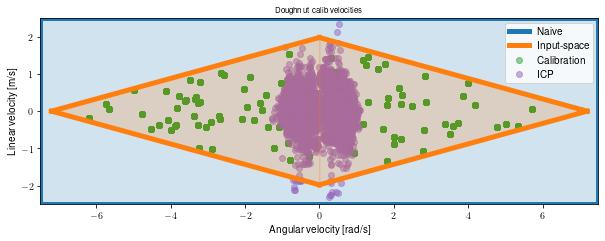

In [62]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": "Helvetica",
# })
# plt.rc('axes', titlesize=8)
# plt.rc('axes', labelsize=10)
# plt.rc('xtick', labelsize=10)
# plt.rc('ytick', labelsize=10)

fig, ax = plt.subplots(1, 1)
fig.set_figheight(10)
fig.set_figwidth(10)

min_wheel_vel = -12
max_wheel_vel = 12

maximum_linear_vel_negative = ideal_diff_drive.compute_body_vel(np.array([min_wheel_vel, min_wheel_vel]))[0]
maximum_linear_vel_positive = ideal_diff_drive.compute_body_vel(np.array([max_wheel_vel, max_wheel_vel]))[0]
maximum_angular_vel_negative = ideal_diff_drive.compute_body_vel(np.array([max_wheel_vel, min_wheel_vel]))[1]
maximum_angular_vel_positive = ideal_diff_drive.compute_body_vel(np.array([min_wheel_vel, max_wheel_vel]))[1]
print(maximum_angular_vel_negative)

# ax.spines['left'].set_position('zero')
# ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_position('zero')
# ax.spines['top'].set_color('none')

x_min = -7.5
x_max = 7.5
y_min = -2.5
y_max = 2.5

ax.set_xlim(x_min, x_max)
ax.set_xlabel('Angular velocity [rad/s]')
# ax.set_xticks([x_min, x_max])
# ax.text(x_min + x_min/10, x_min/10, 'Angular velocity [rad/s]', rotation='vertical')
ax.set_ylim(y_min, y_max)
ax.set_ylabel('Linear velocity [m/s]')
# ax.set_yticks([y_min, y_max])
# ax.text(y_min/2, y_max + y_max/10, 'Linear velocity [m/s]', rotation='horizontal')

num_points = 100
line_width = 5
alpha = 0.2

x_min = -7.5
x_max = 7.5
y_min = -2.5
y_max = 2.5

cmd_angular_vel_linspace = np.linspace(x_min, x_max, num_points)
cmd_linear_max_vel_linspace = np.linspace(y_max, y_max, num_points)
cmd_linear_min_vel_linspace = np.linspace(y_min, y_min, num_points)

## plot initial input space
ax.plot(cmd_angular_vel_linspace, cmd_linear_min_vel_linspace, color='C0', lw=line_width, label='Naive')
ax.plot(cmd_angular_vel_linspace, cmd_linear_max_vel_linspace, color='C0', lw=line_width)
ax.vlines(x_min, y_min, y_max, color='C0', lw=line_width)
ax.vlines(x_max, y_min, y_max, color='C0', lw=line_width)
ax.fill_between(cmd_angular_vel_linspace, cmd_linear_max_vel_linspace, y2=cmd_linear_min_vel_linspace, alpha=alpha, color='C0')

## plot characterized input space
char_angular_vel_linspace_negative = np.linspace(maximum_angular_vel_negative, 0, int(num_points / 2)).flatten()
char_angular_vel_linspace_positive = np.linspace(0, maximum_angular_vel_positive, int(num_points / 2)).flatten()
char_q1_vel_linspace = np.linspace(0, maximum_linear_vel_positive, int(num_points / 2)).flatten()
char_q2_vel_linspace = np.linspace(maximum_linear_vel_positive, 0, int(num_points / 2)).flatten()
char_q3_vel_linspace = np.linspace(maximum_linear_vel_negative, 0, int(num_points / 2)).flatten()
char_q4_vel_linspace = np.linspace(0, maximum_linear_vel_negative, int(num_points / 2)).flatten()

q1_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q1_vel_linspace, color='C1', lw=line_width, label='Input-space')
q2_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q2_vel_linspace, color='C1', lw=line_width)
q3_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q3_vel_linspace, color='C1', lw=line_width)
q4_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q4_vel_linspace, color='C1', lw=line_width)

cmd_scatter = ax.scatter(steady_state_idd_body_vel_yaw, steady_state_idd_body_vel_x, color='C2', label='Calibration', alpha = 0.5)
cmd_scatter = ax.scatter(steady_state_icp_body_vel_yaw, steady_state_icp_body_vel_x, color='C4', label='ICP', alpha = 0.5)

ax.fill_between(char_angular_vel_linspace_negative, char_q1_vel_linspace, y2=char_q4_vel_linspace, alpha=alpha, color='C1')
ax.fill_between(char_angular_vel_linspace_positive, char_q2_vel_linspace, y2=char_q3_vel_linspace, alpha=alpha, color='C1')
ax.set_title('Doughnut calib velocities')

ax.set_aspect('equal')

ax.legend()

plt.savefig('figs/husky_icp.png', dpi=500)